In [83]:
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [90]:
import torch
import pandas as pd
import umap
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pylab as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# latent = torch.load('latent.pt')
dfz = pd.read_pickle('latent.pickle')
z_markers = dfz.columns

In [4]:
df = pd.read_pickle('x_train.pickle')
x_markers = df.columns

In [5]:
# Make a umap of the latent space
def computeUMAProjectionOfLatentSpace(df, display=True):
    
    df = df.sample(1000)
    latent = df.drop(columns=["source"])

    # Compute t-SNE embedding of latent space
    print("Computing umap embedding...")
    model = umap.UMAP(n_components=2, random_state=0)
    X_umap = model.fit_transform(latent)

    # Plot images according to t-sne embedding
    if display:
        print("Plotting umap visualization...")
        plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df.source)
        plt.show()
    else:
        return X_umap

Computing umap embedding...
Plotting umap visualization...


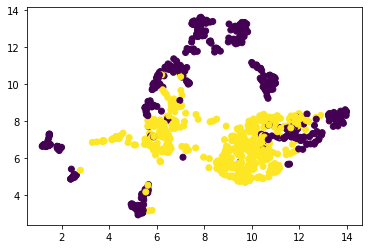

In [6]:
computeUMAProjectionOfLatentSpace(df)

Computing umap embedding...
Plotting umap visualization...


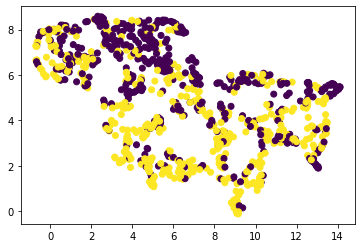

In [7]:
computeUMAProjectionOfLatentSpace(dfz)

In [5]:
# Step 1: Get the distances matrix
sample = dfz.sample(1000)
sample_clean = sample.drop(columns=["source"])
nrst_neigh = NearestNeighbors(n_neighbors = 100, algorithm = 'auto')
nrst_neigh.fit(sample_clean)
distances, indices = nrst_neigh.kneighbors(sample_clean)


In [6]:
indices

array([[  0, 832, 291, ..., 700, 679, 499],
       [  1, 891, 325, ..., 386, 197,  44],
       [  2, 266, 922, ..., 468, 613, 898],
       ...,
       [997, 221,  68, ..., 611,  37, 729],
       [998, 150,  64, ...,  32, 485, 797],
       [999,  78,   6, ..., 547, 659, 229]])

In [7]:
indices_df = pd.DataFrame(indices, index=sample_clean.index, dtype="Int64")
indices_df['source'] = sample.source
indices_df.to_csv('nn_indices.csv')

distances_df = pd.DataFrame(distances, index=sample_clean.index)
distances_df['source'] = sample.source
distances_df.to_csv('nn_distances.csv')


In [8]:
def transform_indices(indices_df):    
    # Transforms indices of nearest neighbors from sample to fit the indices of the larger dataframe.
    indices_new = np.array([indices_df.index[x] for x in indices_df.values.flatten()]).reshape(indices_df.shape)
    indices_new = pd.DataFrame(indices_new, index=indices_df.index)
    return indices_new



In [9]:
indices_df = transform_indices(pd.read_csv('nn_indices.csv', index_col="Unnamed: 0"))

In [10]:
# Replace all the neighbors from the same source with NaNs
pbmc_samples = indices_df[sample.source==0]
pbmc_ids = list(pbmc_samples.index)

nsclc_samples = indices_df[sample.source==1]
nsclc_ids = list(nsclc_samples.index)

pbmc_indices = pbmc_samples.replace(pbmc_ids, np.NaN)
nsclc_indices = nsclc_samples.replace(nsclc_ids, np.NaN)



In [11]:
# The original dataset
ori = pd.read_csv("original_df.csv", index_col="Unnamed: 0")
ori = ori.drop(columns=['id', 'Time', 'Eventlength', 'sample'])
# Remove duplicate ids
ori = ori[~ori.index.duplicated(keep='first')]

In [83]:
ori_pbmc = ori.loc[pbmc_ids,:]
ori_nsclc = ori.loc[nsclc_ids,:]

In [86]:
temp_ori = ori.drop(columns=['batch'])
non_missing_columns = list(temp_ori[temp_ori.columns[~temp_ori.isnull().any()]].columns)
non_missing_columns

['CXCR5',
 'CCR6',
 'CD45RA',
 'TIM3',
 'PD1',
 'CTLA4',
 'HLADR',
 'ICOS',
 'CXCR3',
 'CD3',
 'CD25',
 'CD4',
 'CD127',
 'source']

In [93]:
pd.options.mode.chained_assignment = None  # default='warn'

temp_ori = ori.drop(columns=['batch'])
non_missing_columns = list(temp_ori[temp_ori.columns[~temp_ori.isnull().any()]].columns)

imputed_df = pd.DataFrame()

indices = list(indices_df.index)[:10]

for x in indices:
    sample = temp_ori.loc[x]
    sample_nans = temp_ori.loc 
    # Get the indices of all the neighbors from differnt sources (we set same source to be na)
    nn_indices = indices_df.loc[x,:].dropna() 
    # Get the actual neighbor samples
    neighbors = temp_ori.loc[nn_indices,:]
    # Get the markers that need to be imputed
    missing_markers = list(sample[sample.isna()].index)
    # # Get the mean for each marker from the neighbors 
    imputed_markers = pd.DataFrame(neighbors.mean()).T
    imputed_df = pd.concat([imputed_df, imputed_markers])

imputed_df.index = indices

# Get the existing markers
non_missing_imputed_df = imputed_df[non_missing_columns]
non_missing_ori = temp_ori[non_missing_columns]

non_missing_ori = non_missing_ori.loc[non_missing_imputed_df.index, non_missing_imputed_df.columns]
mse = mean_squared_error(non_missing_ori, non_missing_imputed_df)
mse

0.03745567635422493

In [26]:
pd.options.mode.chained_assignment = None  # default='warn'

non_missing_columns = list(ori[ori.columns[~ori.isnull().any()]].columns)
# df = pd.DataFrame(columns=)
diff_df = pd.DataFrame(columns=non_missing_columns)
for x in list(indices_df.index)[:10]:
    ori_relevant = ori[non_missing_columns]
#     sample = ori_relevant.loc[x]
    sample_nans = ori_relevant.loc 
    # Get the indices of all the neighbors from differnt sources (we set same source to be na)
    nn_indices = indices_df.loc[x,:].dropna() 
    # Get the actual neighbor samples
    neighbors = ori_relevant.loc[nn_indices,:]
    # Get the markers that need to be imputed
    missing_markers = list(sample[sample.isna()].index)
    non_missing_markers = list(sample[sample.notna()].index)
    
    # Get the mean for each marker from the neighbors 
    imputed_markers = neighbors[missing_markers].mean()
    imputed_existing_markers = neighbors[non_missing_markers].mean()
    # Assign the missing markers with the imputed ones
    sample.loc[missing_markers] = imputed_markers
    diff = sample.loc[non_missing_markers] - imputed_existing_markers
    
    diff_df = pd.concat([diff_df, pd.DataFrame(diff).T])
    # Add to a new dataframe to not modify the data
    df = pd.concat([df, pd.DataFrame(sample).T])
diff_df

,CXCR5,CCR6,CD45RA,TIM3,PD1,CTLA4,HLADR,ICOS,CXCR3,CD3,CD25,CD4,CD127,batch,source
469852,0.000000,0.000000,0.663348,0.000000,0.000000,0.121240,0.000000,0.117615,0.274861,0.790794,0.033396,0.637174,0.119963,B,0
1166256,0.000000,0.039760,0.304395,0.021601,0.048446,0.032879,0.000000,0.117615,0.658323,0.649504,0.257103,0.704655,0.567618,B,0
717393,0.000000,0.000000,0.321747,0.000000,0.000000,0.320676,0.000000,0.041083,0.000000,0.658055,0.065556,0.574736,0.119963,B,0
487227,0.034802,0.249934,0.770787,0.000000,0.000000,0.000000,0.055889,0.000000,0.137390,0.539940,0.065556,0.000000,0.186326,B,0
732566,0.358204,0.146614,0.231794,0.000000,0.000000,0.000000,0.000000,0.117615,0.047990,0.566302,0.270512,0.642286,0.477332,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151400,0.764706,0.000000,0.152797,0.000000,0.058879,0.155260,0.226276,0.000000,0.389790,0.317921,0.000000,0.000000,0.295977,A,1
227260,0.310049,0.000000,0.000000,0.000000,0.597686,0.220017,0.021984,0.074637,0.459418,0.534038,0.000000,0.000000,0.369722,A,1
255548,0.679900,0.191901,0.428602,0.000000,0.000000,0.296603,0.251439,0.074637,0.104780,0.476088,0.044971,0.242419,0.110963,A,1
123310,0.000000,0.000000,0.237074,0.000000,0.230915,0.000000,0.286123,0.000000,0.284998,0.486567,0.000000,0.000000,0.507720,A,1


In [ ]:
#take a sample from df1, only look at markers that actually exist (non-NaNs)
#find neighbors that belong to df1
#calculate the mean of df1 for all neighbors
#compare that mean to the real value of that existing marker
#calculate difference